In [1]:
import keras
from keras import layers
from keras.layers import Dense, Dropout, Activation, Flatten, Reshape
from keras.layers import Conv1D,UpSampling1D,MaxPooling1D,concatenate
from keras.layers import BatchNormalization
import keras.models as models
from tensorflow.keras.callbacks import LambdaCallback, EarlyStopping
import tensorflow as tf
import keras.backend as K
from matplotlib import pyplot as plt
import random

import scipy.signal as signal
from sklearn.model_selection import KFold, train_test_split

import wandb
wandb.login()

2024-07-09 15:24:44.092842: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: lana-caldarevic1. Use `wandb login --relogin` to force relogin


True

In [2]:
def create_model(size_0, input_size, regularizer, dp, kernel_size):
	data_shape = input_size
	size_0=size_0
	size_1=size_0*2
	size_2=size_1*2
	kernel_size=kernel_size
	regularizer=regularizer
	dp=dp

	in_data= layers.Input(shape=(data_shape,1))
	conv0 = Conv1D(size_0, kernel_size ,kernel_regularizer=keras.regularizers.l2(regularizer), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(in_data)
	conv0=BatchNormalization()(conv0)
	conv0 = Conv1D(size_0, kernel_size ,kernel_regularizer=keras.regularizers.l2(regularizer) ,  activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv0)
	conv0=BatchNormalization()(conv0)
	pool0 = MaxPooling1D(pool_size=2)(conv0)
	conv1 = Conv1D(size_1, kernel_size ,kernel_regularizer=keras.regularizers.l2(regularizer), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool0)
	conv1=BatchNormalization()(conv1)
	conv1_2 = Conv1D(size_1, kernel_size ,kernel_regularizer=keras.regularizers.l2(regularizer) ,  activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
	conv1_2=BatchNormalization()(conv1_2)
	conv1_2=Dropout(dp)(conv1_2)
	pool1_2 = MaxPooling1D(pool_size=2)(conv1_2)
	conv2 = Conv1D(size_2, kernel_size ,kernel_regularizer=keras.regularizers.l2(regularizer) ,  activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1_2)
	conv2=BatchNormalization()(conv2)
	conv2 = Conv1D(size_2, kernel_size ,kernel_regularizer=keras.regularizers.l2(regularizer) ,  activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
	conv2=BatchNormalization()(conv2)
	up10 = Conv1D(size_2, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling1D(size = 2)(conv2))
	up10=BatchNormalization()(up10)
	merge10 = concatenate([conv1_2,up10], axis = 2)
	conv10 = Conv1D(size_1, kernel_size ,kernel_regularizer=keras.regularizers.l2(regularizer) ,  activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge10)
	conv10=BatchNormalization()(conv10)
	conv10 = Conv1D(size_1, kernel_size ,kernel_regularizer=keras.regularizers.l2(regularizer) ,  activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv10)
	conv10=BatchNormalization()(conv10)
	conv10=Dropout(dp)(conv10)
	up10_1 = Conv1D(size_1, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling1D(size = 2)(conv10))
	up10_1=BatchNormalization()(up10_1)
	merge10_1 = concatenate([conv0,up10_1], axis = 2)
	conv10 = Conv1D(size_0, kernel_size ,kernel_regularizer=keras.regularizers.l2(regularizer) ,  activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge10_1)
	conv10=BatchNormalization()(conv10)
	conv10 = Conv1D(size_0, kernel_size ,kernel_regularizer=keras.regularizers.l2(regularizer) ,  activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv10)
	conv10=BatchNormalization()(conv10)
	out_data = Conv1D(1, kernel_size, activation = 'sigmoid', padding='same')(conv10)
	model = models.Model(inputs=[in_data], outputs=[out_data])
	model.summary()
	return model

In [3]:
def train(config=None):
    if config:
        wandb.init(config=config, project="fantasia-hp-tuning")
    else:
        wandb.init()
        config = wandb.config

    lr = wandb.config.learning_rate
    regularizer = wandb.config.regularizer
    dp = wandb.config.dp
    start_filters = wandb.config.start_filters
    kernel_size = wandb.config.kernel_size
    batch_size = wandb.config.batch_size

    seed = 0
    train_val_patients, test_patients = train_test_split(patients, test_size=0.15, random_state=seed)
    kf = KFold(n_splits=5, shuffle=True, random_state=seed)

    sampling_rate = 250
    seconds_window = 32
    downsampled_window_size = 1024
    window_size = sampling_rate * seconds_window

    validation_results = []
    train_results = []

    for fold, (train_index, val_index) in enumerate(kf.split(train_val_patients)):
        train_patients = [train_val_patients[i] for i in train_index]
        val_patients = [train_val_patients[i] for i in val_index]

        windows_ecg_train, windows_resp_train = process_data_segment(data_filled, window_size, downsampled_window_size, train_patients)
        windows_ecg_validation, windows_resp_validation = process_data_segment(data_filled, window_size, downsampled_window_size, val_patients)

        model = create_model(start_filters, 1024, regularizer, dp, kernel_size)
        adm = tf.keras.optimizers.Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999, amsgrad=False)
        model.compile(loss='mse', metrics=[correlation, 'mse'], optimizer=adm)

        def log_representations_images(epoch, logs):
            wandb.log({
                "loss": logs['loss'],
                "CC": logs['correlation'],
                "mse": logs['mse'],
                "val_loss": logs['val_loss'],
                "val_CC": logs['val_correlation'],
                "val_mse": logs['val_mse']
            })
            fig, ax = plt.subplots(2, 2, figsize=(12, 8))
            fig.suptitle('Ground truth vs. Prediction')

            for row in range(2):
                train_idx = np.random.randint(0, windows_ecg_train.shape[0])
                val_idx = np.random.randint(0, windows_ecg_validation.shape[0])

                to_predict_train = np.array([windows_ecg_train[train_idx]])
                ground_truth_train = windows_resp_train[train_idx]
                prediction_train = model.predict(to_predict_train)[0]
                prediction_train_score = model.evaluate(to_predict_train, np.array([ground_truth_train]), verbose=0)

                to_predict_validation = np.array([windows_ecg_validation[val_idx]])
                ground_truth_validation = windows_resp_validation[val_idx]
                prediction_validation = model.predict(to_predict_validation)[0]
                prediction_validation_score = model.evaluate(to_predict_validation, np.array([ground_truth_validation]), verbose=0)

                ax[row, 0].plot(ground_truth_train, label='Ground Truth')
                ax[row, 0].plot(prediction_train, label='Prediction')
                ax[row, 0].set_title(f"Train Loss: {prediction_train_score[0]:.4f}")
                ax[row, 0].legend()

                ax[row, 1].plot(ground_truth_validation, label='Ground Truth')
                ax[row, 1].plot(prediction_validation, label='Prediction')
                ax[row, 1].set_title(f"Valid Loss: {prediction_validation_score[0]:.4f}")
                ax[row, 1].legend()

            wandb.log({
                "predictions_visualization": wandb.Image(fig)
            }, commit=False)
            plt.close(fig)

        # Early stopping callback
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

        run_name = wandb.run.name
        checkpoint_path = f"/home/lcaldarevic/workspace/ecg_derived_resp_dl/notebooks/models/{run_name}.weights.h5"
        checkpoint_dir = os.path.dirname(checkpoint_path)

        cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=True,
                                                         verbose=1)

        print("model training starting")
        print(windows_ecg_train[:, :, :].shape)
        history = model.fit(
            windows_ecg_train[:, :, :], windows_resp_train[:, :, :],
            epochs=200,
            batch_size=batch_size,
            shuffle=True,
            callbacks=[
                LambdaCallback(on_epoch_end=log_representations_images),
                early_stopping,
                cp_callback
            ],
            validation_data=(windows_ecg_validation[:, :, :], windows_resp_validation[:, :, :])
        )

        # Log fold-specific results
        val_loss = np.min(history.history['val_loss'])
        val_cc = np.max(history.history['val_correlation'])
        val_mse = np.min(history.history['val_mse'])

        validation_results.append((val_loss, val_cc, val_mse))

        wandb.log({
            "fold": fold + 1,
            "val_loss": val_loss,
            "val_cc": val_cc,
            "val_mse": val_mse
        })

        print(f"Fold {fold+1} - Valid Loss: {val_loss:.4f}")
        print(f"Fold {fold+1} - Valid Correlation: {val_cc:.4f}")
        print(f"Fold {fold+1} - Valid MSE: {val_mse:.4f}")

        # Optionally, evaluate on the training set
        train_loss = np.min(history.history['loss'])
        train_cc = np.max(history.history['correlation'])
        train_mse = np.min(history.history['mse'])

        train_results.append((train_loss, train_cc, train_mse))

        wandb.log({
            "fold": fold + 1,
            "train_loss": train_loss,
            "train_cc": train_cc,
            "train_mse": train_mse
        })

        print(f"Fold {fold+1} - Train Loss: {train_loss:.4f}")
        print(f"Fold {fold+1} - Train Correlation: {train_cc:.4f}")
        print(f"Fold {fold+1} - Train MSE: {train_mse:.4f}")

    # Aggregate final results across all folds
    avg_valid_loss = np.mean([res[0] for res in validation_results])
    avg_valid_cc = np.mean([res[1] for res in validation_results])
    avg_valid_mse = np.mean([res[2] for res in validation_results])

    avg_train_loss = np.mean([res[0] for res in train_results])
    avg_train_cc = np.mean([res[1] for res in train_results])
    avg_train_mse = np.mean([res[2] for res in train_results])

    # Log the aggregated results to W&B
    wandb.log({
        "avg_valid_loss": avg_valid_loss,
        "avg_valid_cc": avg_valid_cc,
        "avg_valid_mse": avg_valid_mse,
        "avg_train_loss": avg_train_loss,
        "avg_train_cc": avg_train_cc,
        "avg_train_mse": avg_train_mse
    })

    print(f"Average Valid Loss: {avg_valid_loss:.4f}")
    print(f"Average Valid Correlation: {avg_valid_cc:.4f}")
    print(f"Average Valid MSE: {avg_valid_mse:.4f}")

    print(f"Average Train Loss: {avg_train_loss:.4f}")
    print(f"Average Train Correlation: {avg_train_cc:.4f}")
    print(f"Average Train MSE: {avg_train_mse:.4f}")

    wandb.finish()

In [4]:
import tensorflow as tf

def correlation(x, y):
    min_y = tf.math.reduce_min(y)
    max_y = tf.math.reduce_max(y)
    r_up = tf.math.subtract(y, min_y)
    r_down = max_y - min_y
    new_y = r_up / r_down
    
    mx = tf.math.reduce_mean(x)
    my = tf.math.reduce_mean(y)
    xm, ym = x - mx, y - my
    r_num = tf.reduce_sum(tf.multiply(xm, ym))
    r_den = tf.sqrt(tf.multiply(tf.reduce_sum(tf.square(xm)), tf.reduce_sum(tf.square(ym))))
    r = r_num / r_den
    r = tf.maximum(tf.minimum(r, 1.0), -1.0)
    
    return 1 - r

In [5]:
import wfdb
import pandas as pd
import os
import numpy as np
def load_fantasia():
    files = os.listdir("/home/lcaldarevic/workspace/fantasia-database-1.0.0/")
    files = [s.replace('.dat', '') for s in files if ".dat" in s]
    
    data_fantasia = {}
    patients_fantasia = []
    
    for i, participant in enumerate(files):
        patients_fantasia.append(participant)
    
        data, info = wfdb.rdsamp("/home/lcaldarevic/workspace/fantasia-database-1.0.0/" + participant)
    
        # Get signal
        data = pd.DataFrame(data, columns=info["sig_name"])
        data_fantasia[participant] = np.array([data["ECG"], data["RESP"]])

    return data_fantasia, patients_fantasia

data, patients = load_fantasia()

In [6]:
def process_data_segment(data, window_size, downsampled_window_size, patient_indices, method='clipping'):
    overlap = 1 / 2

    windows_ecg = []
    windows_resp = []

    for record_index in patient_indices:
        N = len(data[record_index][0, :])
        max_step = int(N // (window_size * overlap))
        for step in range(1, max_step - 1):
            start_idx = int(step) * int(window_size * overlap)
            end_idx = start_idx + window_size
            recrd_ecg = data[record_index][0, start_idx:end_idx]
            recrd_resp = data[record_index][1, start_idx:end_idx]

            if recrd_ecg.min() < recrd_ecg.max():
                # Normalize ECG using mean and std deviation
                #normalized_ecg = (recrd_ecg - recrd_ecg.mean()) / recrd_ecg.std()

                normalized_ecg = (recrd_ecg - recrd_ecg.min()) / (recrd_ecg.max() - recrd_ecg.min())
                normalized_ecg = signal.resample(normalized_ecg, downsampled_window_size)

                if recrd_resp.min() < recrd_resp.max():
                    normalized_resp = (recrd_resp - recrd_resp.min()) / (recrd_resp.max() - recrd_resp.min())
                    normalized_resp = signal.resample(normalized_resp, downsampled_window_size)
                    
                    windows_ecg.append(np.float32(normalized_ecg))
                    windows_resp.append(np.float32(normalized_resp))


    windows_ecg = np.array(windows_ecg)[:, :, np.newaxis]
    windows_resp = np.array(windows_resp)[:, :, np.newaxis]

    print(windows_ecg.shape)
    print(windows_resp.shape)

    return windows_ecg, windows_resp

In [7]:
import neurokit2 as nk
sampling_rate = 250
def fill_nan_values(data):
    filled_data = {}
    for participant, signals in data.items():
        ecg_data = signals[0, :]
        resp_data = signals[1, :]

        ecg_filled = nk.signal_interpolate(ecg_data, method='linear')
        ecg_filled = nk.ecg_clean(ecg_filled, sampling_rate=sampling_rate, method="neurokit")
        
        resp_filled = nk.signal_interpolate(resp_data, method='linear')
        resp_filled = nk.rsp_clean(resp_filled, sampling_rate=sampling_rate)
        
        filled_data[participant] = np.vstack((ecg_filled, resp_filled))
    
    return filled_data

def check_for_nan(data, patients):
    for patient in patients:
        if np.isnan(data[patient]).any():
            print(f"NaN values found in patient data index: {patient}")

check_for_nan(data, patients)

data_filled = fill_nan_values(data)

check_for_nan(data_filled, patients)

NaN values found in patient data index: f2o10
NaN values found in patient data index: f2y09
NaN values found in patient data index: f2o06
NaN values found in patient data index: f2y10
NaN values found in patient data index: f2o09
NaN values found in patient data index: f2y01
NaN values found in patient data index: f2y08
NaN values found in patient data index: f2y05
NaN values found in patient data index: f2o05
NaN values found in patient data index: f2o02


In [8]:
seed = 0
train_val_patients, test_patients = train_test_split(patients, test_size=0.15, random_state=seed)
train_val_patients_array = np.array(train_val_patients)

train_patients, val_patients = train_test_split(train_val_patients, test_size=0.20, random_state=seed)

sampling_rate = 250
seconds_window = 32
downsampled_window_size = 1024 # signal size
window_size = sampling_rate * seconds_window # window size to split by

windows_ecg_train, windows_resp_train = process_data_segment(data_filled, window_size, downsampled_window_size, train_patients)
windows_ecg_validation, windows_resp_validation = process_data_segment(data_filled, window_size, downsampled_window_size, val_patients)
windows_ecg_test, windows_resp_test = process_data_segment(data_filled, window_size, downsampled_window_size, test_patients)

(11930, 1024, 1)
(11930, 1024, 1)
(3115, 1024, 1)
(3115, 1024, 1)
(2804, 1024, 1)
(2804, 1024, 1)


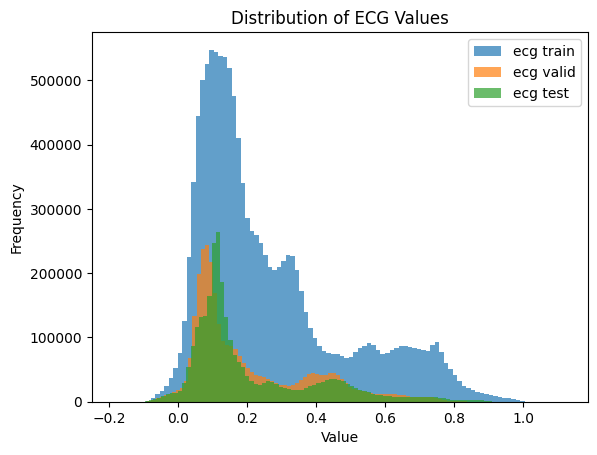

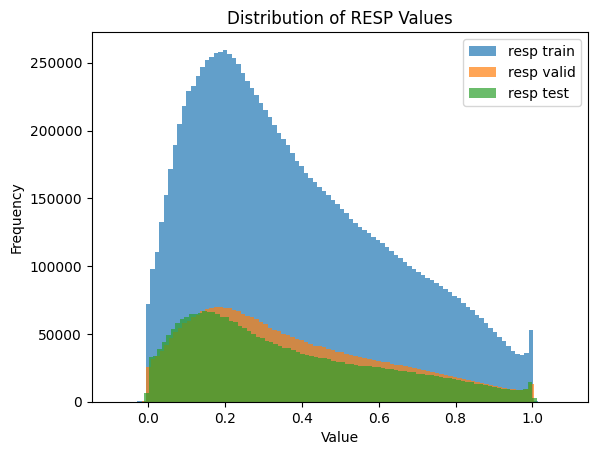

In [9]:
plt.hist(windows_ecg_train.flatten(), bins=100, alpha=0.7, label="ecg train")
plt.hist(windows_ecg_validation.flatten(), bins=100, alpha=0.7, label="ecg valid")
plt.hist(windows_ecg_test.flatten(), bins=100, alpha=0.7, label="ecg test")
plt.title('Distribution of ECG Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

plt.hist(windows_resp_train.flatten(), bins=100, alpha=0.7, label="resp train")
plt.hist(windows_resp_validation.flatten(), bins=100, alpha=0.7, label="resp valid")
plt.hist(windows_resp_test.flatten(), bins=100, alpha=0.7, label="resp test")
plt.title('Distribution of RESP Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [12]:
def create_sweep_config():
    return {
        'method': 'random',
        'metric': {
            'name': 'val_loss',
            'goal': 'minimize'
        },
        'parameters': {
             'learning_rate': {
                'distribution': 'log_uniform_values',
                'min': 1e-4,
                'max': 1e-2
            },
            'regularizer': {
                'distribution': 'log_uniform_values',
                'min': 1e-4,
                'max': 1e-1
            },
            'dp': {
                'values': [0.1, 0.3, 0.5]
            },
            'start_filters': {
                'values': [4, 8, 16]
            },
            'kernel_size': {
                'values': [13, 27, 51]
            },
            'batch_size': {
                'values': [256]
            }
            
        }
    }

In [ ]:
sweep_config = create_sweep_config()
sweep_id = wandb.sweep(sweep_config, project="fantasia-hp-tuning")

wandb.agent(sweep_id, train)

Create sweep with ID: mv0u3xpn
Sweep URL: https://wandb.ai/lana-caldarevic1/fantasia-hp-tuning/sweeps/mv0u3xpn


wandb: Agent Starting Run: 3eq9gdf6 with config:
wandb: 	batch_size: 256
wandb: 	dp: 0.5
wandb: 	kernel_size: 27
wandb: 	learning_rate: 0.00023118241530099864
wandb: 	regularizer: 0.00019638536555924684
wandb: 	start_filters: 8
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


2024-07-08 14:35:35.103330: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1015 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6
2024-07-08 14:35:35.104057: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22198 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:21:00.0, compute capability: 8.6


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1024, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 1024, 8)   │        224 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1024, 8)   │         32 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 1024, 8)   │      1,736 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1024, 8)   │         32 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 512, 8)    │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 512, 16)   │      3,472 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 16)   │         64 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 512, 16)   │      6,928 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 16)   │         64 │ conv1d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512, 16)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 256, 16)   │          0 │ dropout[0][0]     │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 256, 32)   │     13,856 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 32)   │        128 │ conv1d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 256, 32)   │     27,680 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 32)   │        128 │ conv1d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling1d       │ (None, 512, 32)   │          0 │ batch_normalizat… │
│ (UpSampling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 512, 32)   │      2,080 │ up_sampling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 32)   │        128 │ conv1d_6[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 92,161 (360.00 KB)

 Trainable params: 91,745 (358.38 KB)

 Non-trainable params: 416 (1.62 KB)

model training starting
(11930, 1024, 1)
Epoch 1/200


I0000 00:00:1720442139.515845 3857417 service.cc:145] XLA service 0x7946f002ded0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1720442139.515898 3857417 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
I0000 00:00:1720442139.515902 3857417 service.cc:153]   StreamExecutor device (1): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-07-08 14:35:39.665259: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-08 14:35:40.154410: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


 5/47 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - correlation: 1.0036 - loss: 0.1958 - mse: 0.1324

I0000 00:00:1720442151.499125 3857417 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 745ms/stepep - correlation: 0.9899 - loss: 0.1820 - mse: 0.11
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

Epoch 1: val_loss improved from inf to 0.13592, saving model to /home/lcaldarevic/workspace/ecg_derived_resp_dl/notebooks/models/confused-sweep-1.weights.h5
47/47 ━━━━━━━━━━━━━━━━━━━━ 31s 332ms/step - correlation: 0.9897 - loss: 0.1817 - mse: 0.1191 - val_correlation: 0.9846 - val_loss: 0.1359 - val_mse: 0.0759
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/stepep - correlation: 0.9623 - loss: 0.1377 - mse: 0.078
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

Epoch 2: val_loss improved from 0.13592 to 0.12611, saving model to /home/lcaldarevic/workspace/ecg_derived_resp_dl/notebooks/models/confused-sweep-1.weights.h5
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - correlation: 0.9621 - loss: 0.1376 - mse: 0.0787 - val_correla

CC,██▇▄▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▆▆▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mse,█▆▅▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_CC,██▇▅▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂
val_loss,█▇▆▅▄▄▃▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mse,█▇▆▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▂▁▂▂▂▂▂▂▂▂▁▁▂▂▂▂▂▃▂
CC,0.19367
loss,0.02798
mse,0.02137
val_CC,0.53931
val_loss,0.05536


wandb: Agent Starting Run: drg9ef1k with config:
wandb: 	batch_size: 256
wandb: 	dp: 0.3
wandb: 	kernel_size: 13
wandb: 	learning_rate: 0.0002361082458322824
wandb: 	regularizer: 0.00027733895760762955
wandb: 	start_filters: 8
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1024, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 1024, 8)   │        112 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1024, 8)   │         32 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 1024, 8)   │        840 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1024, 8)   │         32 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 512, 8)    │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 512, 16)   │      1,680 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 16)   │         64 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 512, 16)   │      3,344 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 16)   │         64 │ conv1d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512, 16)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 256, 16)   │          0 │ dropout[0][0]     │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 256, 32)   │      6,688 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 32)   │        128 │ conv1d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 256, 32)   │     13,344 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 32)   │        128 │ conv1d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling1d       │ (None, 512, 32)   │          0 │ batch_normalizat… │
│ (UpSampling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 512, 32)   │      2,080 │ up_sampling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 32)   │        128 │ conv1d_6[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 46,241 (180.63 KB)

 Trainable params: 45,825 (179.00 KB)

 Non-trainable params: 416 (1.62 KB)

model training starting
(11930, 1024, 1)
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/stepep - correlation: 0.9970 - loss: 0.2007 - mse: 0.11
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

Epoch 1: val_loss improved from inf to 0.15151, saving model to /home/lcaldarevic/workspace/ecg_derived_resp_dl/notebooks/models/gentle-sweep-2.weights.h5
47/47 ━━━━━━━━━━━━━━━━━━━━ 28s 308ms/step - correlation: 0.9969 - loss: 0.2005 - mse: 0.1135 - val_correlation: 0.9979 - val_loss: 0.1515 - val_mse: 0.0693
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/stepep - correlation: 0.9770 - loss: 0.1634 - mse: 0.083
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

Epoch 2: val_loss improved from 0.15151 to 0.14129, saving model to /home/lcaldarevic/workspace/ecg_derived_resp_dl/notebooks/models/gentle-sweep-2.weights.h5
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - correlation: 

In [ ]:
def plot_signals_in_grid(predicted_signals, true_signals, labels=['Predicted', 'True']):
    fig, axs = plt.subplots(len(predicted_signals)//2, 2, figsize=(20, 50))
    axs = axs.flatten() 

    for i in range(len(predicted_signals)):  
        ax = axs[i]
        pred_signal = predicted_signals[i]
        true_signal = true_signals[i]

        #loss = tf.keras.losses.mse(pred_signal, true_signal)
        #cc = correlation(pred_signal, true_signal)

        # Plotting both signals in the same subplot
        ax.plot(pred_signal, label=labels[0])
        ax.plot(true_signal, label=labels[1], alpha=0.75)
        ax.legend()
        #ax.set_title(f'cc:  {cc}')
    
    plt.tight_layout()
    plt.show()

In [ ]:
plot_signals_in_grid(windows_ecg_train[0:50], windows_resp_train[0:50], ['ecg', 'resp'])

In [ ]:
windows_ecg_train = ecg_scaler.inverse_transform(windows_ecg_train.squeeze(-1))

In [ ]:
windows_resp_train = resp_scaler.inverse_transform(windows_resp_train.squeeze(-1))

In [ ]:
plot_signals_in_grid(windows_ecg_train[0:50], windows_resp_train[0:50], ['ecg', 'resp'])

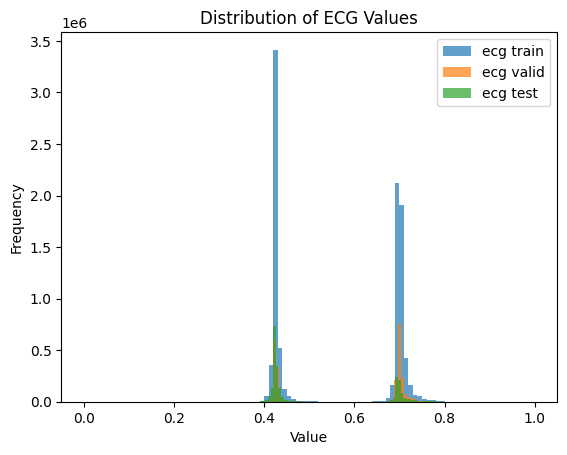

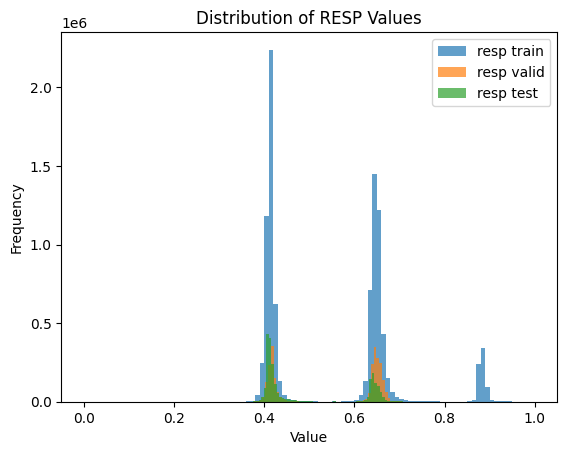

In [29]:
import numpy as np
from scipy.signal import resample
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import wfdb
import pandas as pd
import os
import neurokit2 as nk
import matplotlib.pyplot as plt

# Function to load the signals
def load_fantasia():
    files = os.listdir("/home/lcaldarevic/workspace/fantasia-database-1.0.0/")
    files = [s.replace('.dat', '') for s in files if ".dat" in s]
    
    data_fantasia = {}
    patients_fantasia = []

    for i, participant in enumerate(files):
        patients_fantasia.append(participant)
    
        data, info = wfdb.rdsamp("/home/lcaldarevic/workspace/fantasia-database-1.0.0/" + participant)
    
        # Get signal
        data = pd.DataFrame(data, columns=info["sig_name"])
        ecg_signal = data["ECG"].values
        resp_signal = data["RESP"].values
        
        data_fantasia[participant] = np.vstack((ecg_signal, resp_signal))
    
    return data_fantasia, patients_fantasia

# Function to handle NaN values by interpolation
def fill_nan_values(data):
    filled_data = {}
    for participant, signals in data.items():
        ecg_data = signals[0, :]
        resp_data = signals[1, :]

        if np.isnan(ecg_data).all():
            print(f"All NaN values in ECG signal for participant {participant}. Skipping.")
            continue

        if np.isnan(resp_data).all():
            print(f"All NaN values in RESP signal for participant {participant}. Skipping.")
            continue

        ecg_filled = nk.signal_interpolate(ecg_data, method='linear')
        resp_filled = nk.signal_interpolate(resp_data, method='linear')

        filled_data[participant] = np.vstack((ecg_filled, resp_filled))
    
    return filled_data

# Resample the signals from 250 Hz to 50 Hz
def resample_signal(signal, original_rate, target_rate):
    num_samples = len(signal)
    duration = num_samples / original_rate
    num_samples_resampled = int(duration * target_rate)
    return resample(signal, num_samples_resampled)

# Function to load, interpolate, and resample the signals
def load_and_preprocess_fantasia(target_rate=50):
    data_fantasia, patients_fantasia = load_fantasia()

    # Handle NaN values before resampling
    data_filled = fill_nan_values(data_fantasia)

    processed_data = {}
    for participant, signals in data_filled.items():
        ecg_filled = signals[0, :]
        resp_filled = signals[1, :]

        # Resample signals
        ecg_resampled = resample_signal(ecg_filled, original_rate=250, target_rate=target_rate)
        resp_resampled = resample_signal(resp_filled, original_rate=250, target_rate=target_rate)

        # Check for NaNs after resampling
        if np.isnan(ecg_resampled).any() or np.isnan(resp_resampled).any():
            print(f"NaN values found after resampling for participant {participant}. Skipping.")
            continue
        
        processed_data[participant] = np.vstack((ecg_resampled, resp_resampled))
    
    return processed_data, patients_fantasia

# Split the data by patients
def split_data_by_patients(patients, seed=0):
    train_val_patients, test_patients = train_test_split(patients, test_size=0.15, random_state=seed)
    train_patients, val_patients = train_test_split(train_val_patients, test_size=0.20, random_state=seed)
    return train_patients, val_patients, test_patients

# Flatten the signals for Min-Max Scaling
def flatten_signals(data, patients):
    flattened_ecg = []
    flattened_resp = []
    
    for patient in patients:
        ecg_signal = data[patient][0]
        resp_signal = data[patient][1]
        flattened_ecg.extend(ecg_signal)
        flattened_resp.extend(resp_signal)
    
    return np.array(flattened_ecg).reshape(-1, 1), np.array(flattened_resp).reshape(-1, 1)

# Apply Min-Max Scaling using sklearn's MinMaxScaler
def apply_min_max_scaling(data, patients, scaler_ecg, scaler_resp):
    normalized_data = {}
    
    for patient, signals in data.items():
        if patient not in patients:
            continue
        
        ecg_signal = signals[0]
        resp_signal = signals[1]
        
        ecg_normalized = scaler_ecg.transform(ecg_signal.reshape(-1, 1)).flatten()
        resp_normalized = scaler_resp.transform(resp_signal.reshape(-1, 1)).flatten()
        
        normalized_data[patient] = np.vstack((ecg_normalized, resp_normalized))
    
    return normalized_data

# Function to check for NaN values
def check_for_nan(data, patients):
    for patient in patients:
        if np.isnan(data[patient]).any():
            print(f"NaN values found in patient data index: {patient}")

# Load and preprocess the data
data, patients = load_and_preprocess_fantasia()

# Check for NaN values after preprocessing
check_for_nan(data, patients)

# Split the data by patients
train_patients, val_patients, test_patients = split_data_by_patients(patients)

# Flatten the training signals to fit the scaler
flattened_ecg_train, flattened_resp_train = flatten_signals(data, train_patients)

# Fit Min-Max Scaler on training signals
scaler_ecg = MinMaxScaler()
scaler_resp = MinMaxScaler()

scaler_ecg.fit(flattened_ecg_train)
scaler_resp.fit(flattened_resp_train)

# Apply Min-Max Scaling to training, validation, and test sets
normalized_train_data = apply_min_max_scaling(data, train_patients, scaler_ecg, scaler_resp)
normalized_val_data = apply_min_max_scaling(data, val_patients, scaler_ecg, scaler_resp)
normalized_test_data = apply_min_max_scaling(data, test_patients, scaler_ecg, scaler_resp)

# Extract ECG and RESP signals for plotting distributions
windows_ecg_train = np.concatenate([normalized_train_data[patient][0] for patient in train_patients])
windows_ecg_validation = np.concatenate([normalized_val_data[patient][0] for patient in val_patients])
windows_ecg_test = np.concatenate([normalized_test_data[patient][0] for patient in test_patients])

windows_resp_train = np.concatenate([normalized_train_data[patient][1] for patient in train_patients])
windows_resp_validation = np.concatenate([normalized_val_data[patient][1] for patient in val_patients])
windows_resp_test = np.concatenate([normalized_test_data[patient][1] for patient in test_patients])

# Plot the distributions
plt.hist(windows_ecg_train.flatten(), bins=100, alpha=0.7, label="ecg train")
plt.hist(windows_ecg_validation.flatten(), bins=100, alpha=0.7, label="ecg valid")
plt.hist(windows_ecg_test.flatten(), bins=100, alpha=0.7, label="ecg test")
plt.title('Distribution of ECG Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

plt.hist(windows_resp_train.flatten(), bins=100, alpha=0.7, label="resp train")
plt.hist(windows_resp_validation.flatten(), bins=100, alpha=0.7, label="resp valid")
plt.hist(windows_resp_test.flatten(), bins=100, alpha=0.7, label="resp test")
plt.title('Distribution of RESP Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [30]:
flattened_ecg_train

array([[ 0.05059177],
       [-0.00760027],
       [-0.00258284],
       ...,
       [-0.2371808 ],
       [-0.11333374],
       [-0.11795426]])